# ◆Titanic: Machine Learning from Disaster
### 目的：タイタニック号の乗客のデータから、生存予測をする
### 目的変数をSurvivedとする二値分類問題を予測するML、NNおよびアンサンブル学習モデルを構築する
- kaggle URL:https://www.kaggle.com/c/titanic/data
- Create Date：2020/01/16　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────


![](https://i.ytimg.com/vi/yuMNWt6S0ZA/maxresdefault.jpg)

## 目次

1. [**データ読込**](#data_exploration)
2. [**特徴量エンジニアリング**](#fe)
3. [**モデル評価**](#trymodels)
4. [**交差検証法にて最適なモデルを見つける**](#choose)
5. [**アンサンブル学習**](#ensembling)
6. [**予測結果出力**](#submission)
7. [**Results**](#results)  


## 0.Notebook内で利用する関数の定義

In [1]:
import pydot
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.exceptions import NotFittedError

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

from IPython.display import display

path_train = './input/train.csv'
path_test = './input/test.csv'

def display_confusion_matrix(target, prediction, score=None):
    cm = metrics.confusion_matrix(target, prediction)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    if score:
        score_title = 'Accuracy Score: {0}'.format(round(score, 5))
        plt.title(score_title, size = 14)
    classification_report = pd.DataFrame.from_dict(metrics.classification_report(target, prediction, output_dict=True),
                                                   orient='index')
    display(classification_report.round(2))
    

        
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.query('Total > 0')

Using TensorFlow backend.


## 1.データ読込<a id="data_exploration"></a>

In [2]:
train_df_raw = pd.read_csv(path_train)

display(train_df_raw.head())
display(train_df_raw.describe())
display(train_df_raw.info())
display(draw_missing_data_table(train_df_raw))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


None

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


運賃と性別から適切な乗船港を選択する

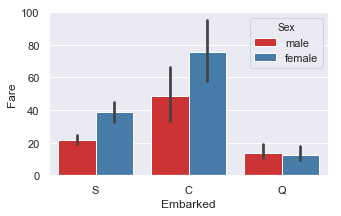

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [3]:
# catplotは質的変数(カテゴリカル変数)と量的変数の関係を上手く描画するためのインターフェイス
figure, axes = plt.subplots(1,1,figsize=(5, 3))
plot = sns.catplot(x="Embarked", y="Fare", hue="Sex", data=train_df_raw, palette=('Set1'), kind="bar", ax=axes)
plt.close(plot.fig)
plt.show()

# EmbarkedがNaNデータ2件を表示
display(train_df_raw[train_df_raw['Embarked'].isnull()])

両方の乗客は、チケットの運賃として80ドルを支払った女性です。さらに、彼らは同じチケットと客室なので、おそらく乗船港だと考えられます！上記の分布によると、シェルブール（C）です。これらの2つの欠損値は、後ほど置き換えます。

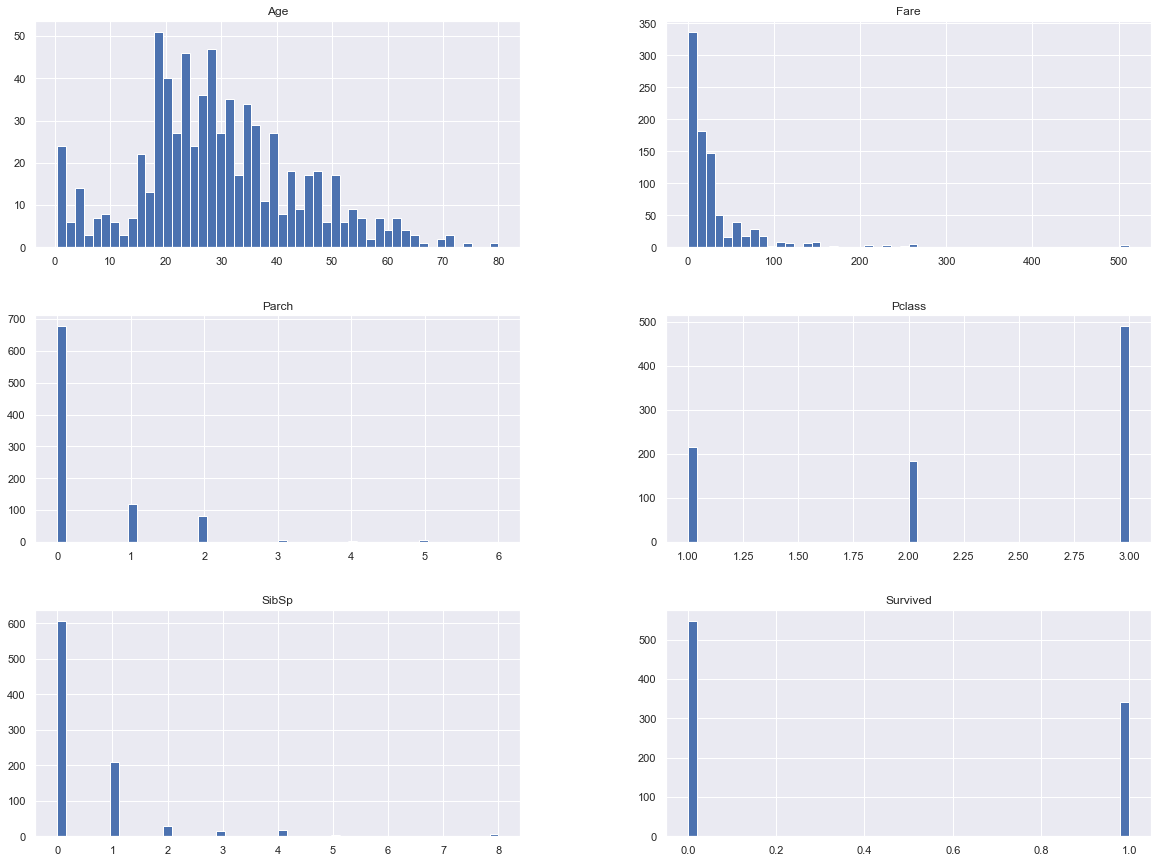

In [4]:
# 数値項目の説明変数についてヒストグラムを確認する
train_df_raw.drop(['PassengerId'], 1).hist(bins=50, figsize=(20,15))
plt.show()

## 2. 特徴量エンジニアリング<a id="fe"></a>

In [5]:
def preprocess_data(df):
    
    p_df = df
        
    ########## 欠損値の補完 ##########
    
    # 乗船港をC(シェルブール)に補完
    p_df['Embarked'].fillna('C', inplace=True)
    
    # 同じクラス性別家族の平均年齢で補完
    p_df['Age'] = p_df.groupby(['Pclass','Sex','Parch','SibSp'])['Age'].transform(lambda x: x.fillna(x.mean()))
    p_df['Age'] = p_df.groupby(['Pclass','Sex','Parch'])['Age'].transform(lambda x: x.fillna(x.mean()))
    p_df['Age'] = p_df.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.mean()))
    
    # 欠損している運賃値と客室の欠落値を置換する
    p_df['Fare'] = p_df['Fare'].interpolate() # pandasで欠損値NaNを前後の値から補間するinterpolate
    p_df['Cabin'].fillna('U', inplace=True)
    
    ########## 特徴量エンジニアリング ##########
    
    # 名前から敬称を作成
    p_df['Title'] = pd.Series((name.split('.')[0].split(',')[1].strip() for name in train_df_raw['Name']), 
                              index=train_df_raw.index)
    p_df['Title'] = p_df['Title'].replace(['Lady', 'the Countess','Countess','Capt', 
                                           'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                           'Jonkheer', 'Dona'], 'Rare')
    p_df['Title'] = p_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    p_df['Title'] = p_df['Title'].replace('Mme', 'Mrs')
    p_df['Title'] = p_df['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
    
    # 同じタイトルを持つ乗客の平均年齢で年齢欠損値を埋める
    p_df['Age'] = p_df.groupby(['Title'])['Age'].transform(lambda x: x.fillna(x.mean()))

    # カテゴリ変数を数値変数に変換する
    p_df['Sex'] = p_df['Sex'].map({'male': 0, 'female': 1})
    p_df['Embarked'] = p_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    # FamillySize、IsAlone、IsChildおよびMother列を作成する
    p_df['FamillySize'] = p_df['SibSp'] + p_df['Parch'] + 1
    p_df['FamillySize'][p_df['FamillySize'].between(1, 5, inclusive=False)] = 2
    p_df['FamillySize'][p_df['FamillySize']>5] = 3
    p_df['IsAlone'] = np.where(p_df['FamillySize']!=1, 0, 1)
    p_df['IsChild'] = p_df['Age'] < 18
    p_df['IsChild'] = p_df['IsChild'].astype(int)
    
    # 船のデッキに対応する文字のみが含まれるように客室の列を変更
    p_df['Cabin'] = p_df['Cabin'].str[:1]
    p_df['Cabin'] = p_df['Cabin'].map({cabin: p for p, cabin in enumerate(set(cab for cab in p_df['Cabin']))})
    
    # 同じチケットを持つ他の乗客が生き残った場合は1に設定され、それ以外の場合は0に設定されるチケットサバイバー列を作成
    p_df['TicketSurvivor'] = pd.Series(0, index=p_df.index)
    tickets = p_df['Ticket'].value_counts().to_dict()
    for t, occ in tickets.items():
        if occ != 1:
            table = train_df_raw['Survived'][train_df_raw['Ticket'] == t]
            if sum(table) != 0:
                p_df['TicketSurvivor'][p_df['Ticket'] == t] = 1
    
    # 抽出元の列を削除
    p_df = p_df.drop(['Name', 'Ticket', 'PassengerId'], 1)    
    
    return p_df

In [6]:
# 訓練データセットを2つのデータセットに分割して、機械学習モデルのパフォーマンスを評価する
train_df = train_df_raw.copy()
X = train_df.drop(['Survived'], 1)
Y = train_df['Survived']

X = preprocess_data(X)
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X.values), index=X.index, columns=X.columns)
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamillySize,IsAlone,IsChild,TicketSurvivor
331,-1.566107,-0.737695,1.181540,-0.474545,-0.473674,-0.074583,3.141145,-0.571933,-0.707550,-0.670389,0.811922,-0.405840,-0.596795
733,-0.369365,-0.737695,-0.483367,-0.474545,-0.473674,-0.386671,-0.308153,-0.571933,-0.707550,-0.670389,0.811922,-0.405840,-0.596795
382,0.827377,-0.737695,0.182596,-0.474545,-0.473674,-0.488854,-0.308153,-0.571933,-0.707550,-0.670389,0.811922,-0.405840,-0.596795
704,0.827377,-0.737695,-0.261380,0.432793,-0.473674,-0.490280,-0.308153,-0.571933,-0.707550,0.668886,-1.231645,-0.405840,-0.596795
813,0.827377,1.355574,-1.741297,3.154809,2.008933,-0.018709,-0.308153,-0.571933,0.263832,2.008162,-1.231645,2.464027,-0.596795


## 3. モデル評価<a id="trymodels"></a>

### **3.1 ロジスティック回帰**

,precision,recall,f1-score,support
0,0.83,0.87,0.85,105
1,0.80,0.74,0.77,74
macro avg,0.81,0.80,0.81,179
micro avg,0.82,0.82,0.82,179
weighted avg,0.81,0.82,0.81,179


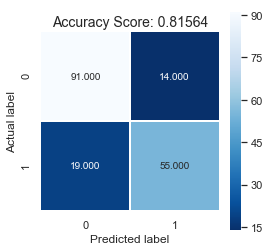

In [7]:
lg = LogisticRegression(solver='lbfgs', random_state=42)
lg.fit(X_train, Y_train)
logistic_prediction = lg.predict(X_test)

# 予測データと真の応答の間の誤差を計算し、混同行列に表示
score = metrics.accuracy_score(Y_test, logistic_prediction)
display_confusion_matrix(Y_test, logistic_prediction, score=score)

### **3.2 決定木**

,precision,recall,f1-score,support
0,0.85,0.90,0.87,105
1,0.84,0.78,0.81,74
macro avg,0.85,0.84,0.84,179
micro avg,0.85,0.85,0.85,179
weighted avg,0.85,0.85,0.85,179


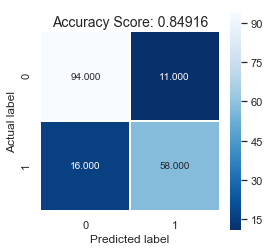

In [8]:
dt = DecisionTreeClassifier(min_samples_split=15, min_samples_leaf=20, random_state=42)
dt.fit(X_train, Y_train)
dt_prediction = dt.predict(X_test)

score = metrics.accuracy_score(Y_test, dt_prediction)
display_confusion_matrix(Y_test, dt_prediction, score=score)

In [9]:
with open("dt.dot", 'w') as f:
    export_graphviz(dt, out_file=f, feature_names=X_test.columns)
try:
    subprocess.check_call(["dot", "-Tpng", "dt.dot", "-o", "dt.png"])
except:
     exit("Could not run dot, ie graphviz, to produce visualization")
        
! dot -Tpng dt.dot > dt.png

![title](dt.png)

### **3.3 SVM**

,precision,recall,f1-score,support
0,0.84,0.92,0.88,105
1,0.87,0.74,0.80,74
macro avg,0.85,0.83,0.84,179
micro avg,0.85,0.85,0.85,179
weighted avg,0.85,0.85,0.85,179


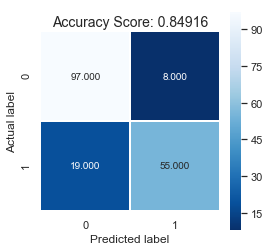

In [10]:
svm = SVC(gamma='auto', random_state=42)
svm.fit(X_train, Y_train)
svm_prediction = svm.predict(X_test)

score = metrics.accuracy_score(Y_test, svm_prediction)
display_confusion_matrix(Y_test, svm_prediction, score=score)

### **3.4 ランダムフォレスト**

,precision,recall,f1-score,support
0,0.87,0.91,0.89,105
1,0.87,0.81,0.84,74
macro avg,0.87,0.86,0.87,179
micro avg,0.87,0.87,0.87,179
weighted avg,0.87,0.87,0.87,179


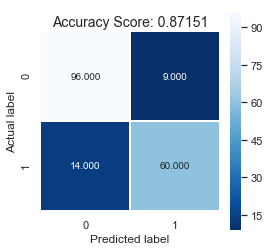

In [11]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, Y_train)
rf_prediction = rf.predict(X_test)

score = metrics.accuracy_score(Y_test, rf_prediction)
display_confusion_matrix(Y_test, rf_prediction, score=score)

### **3.5 ニューラルネットワーク**

ニューラルネットワークは、標準的な機械学習よりも複雑で強力なアルゴリズムであり、ディープラーニングモデルに属します。ニューラルネットワークを構築するには、Kerasを使用します。Kerasは、テンソルフロー用の高レベルAPIです。





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


,precision,recall,f1-score,support
0,0.83,0.91,0.87,105
1,0.86,0.73,0.79,74
macro avg,0.84,0.82,0.83,179
micro avg,0.84,0.84,0.84,179
weighted avg,0.84,0.84,0.84,179


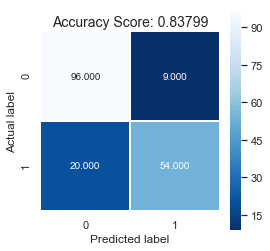

In [12]:
def build_nn(optimizer='adam'):
    
    nn = Sequential()
    
    # https://keras.io/ja/layers/core/
    nn.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(13,)))
    nn.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    nn.add(Dropout(rate=0.5))
    nn.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    nn.add(Dropout(rate=0.5))
    nn.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    
    # コンパイル
    nn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return nn

# オプティマイザ生成
opt = optimizers.Adam(lr=0.001)
nn = build_nn(opt)

# ニューラルネットワーク学習
history = nn.fit(X_train, Y_train, batch_size=16
                  , epochs=30
                  , validation_data=(X_test, Y_test)
                  ,verbose=0# ログを非表示
                 )

# 予測
nn_prediction = nn.predict(X_test)
nn_prediction = (nn_prediction > 0.5) # 確率をバイナリ出力に変換

# 予測データと真の応答の間の誤差を計算し、混同行列に表示
score = metrics.accuracy_score(Y_test, nn_prediction)
display_confusion_matrix(Y_test, nn_prediction, score=score)

## **4. 交差検証法にて最適なモデルを見つける** <a id="choose"></a>

,lg,dt,svm,rf,ann
Mean_accuracy,0.835769,0.824478,0.842693,0.809202,0.842645
Variance,0.054498,0.041880,0.054509,0.044161,0.042323


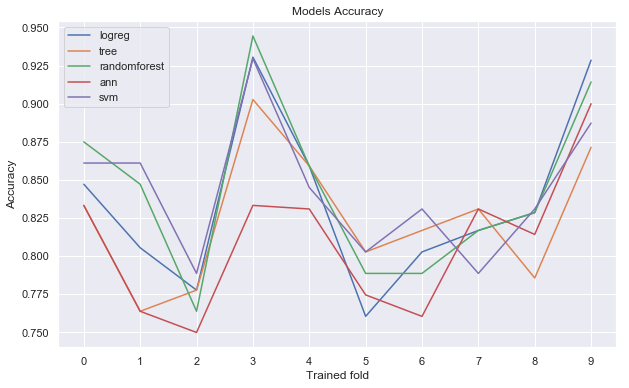

In [13]:
n_folds = 10
cv_score_lg = cross_val_score(estimator=lg, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_dt = cross_val_score(estimator=dt, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_svm = cross_val_score(estimator=svm, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_rf = cross_val_score(estimator=rf, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
# https://keras.io/ja/scikit-learn-api/
cv_score_ann = cross_val_score(estimator=KerasClassifier(build_fn=build_nn, 
                                                         batch_size=16, 
                                                         epochs=20, 
                                                         verbose=0),
                                 X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)

cv_result = {'lg': cv_score_lg, 'dt': cv_score_dt, 'svm': cv_score_svm, 'rf': cv_score_rf, 'ann': cv_score_ann}
cv_data = {model: [score.mean(), score.std()] for model, score in cv_result.items()}
cv_df = pd.DataFrame(cv_data, index=['Mean_accuracy', 'Variance'])
display(cv_df)

plt.figure(figsize=(10,6))
plt.plot(cv_result['lg'])
plt.plot(cv_result['dt'])
plt.plot(cv_result['svm'])
plt.plot(cv_result['rf'])
plt.plot(cv_result['ann'])
plt.title('Models Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Trained fold')
plt.xticks([k for k in range(n_folds)])
plt.legend(['logreg', 'tree', 'randomforest', 'ann', 'svm'], loc='upper left')
plt.show()

## **5. アンサンブル学習** <a id="ensembling"></a>

In [14]:
class EsemblingClassifier:
    
    def __init__(self, verbose=True):
        # コンストラクタ
        self.ann = build_nn(optimizer=optimizers.Adam(lr=0.001))
        self.rf = RandomForestClassifier(n_estimators=300, max_depth=11, random_state=42)
        self.svm = SVC(random_state=42)
        self.trained = False
        self.verbose = verbose
        
    def fit(self, X, y):
        # 学習
        if self.verbose:
            print('-------- Fitting models --------')
        self.ann.fit(X, y, epochs=30, batch_size=16, verbose=0)
        self.rf.fit(X, y)
        self.svm.fit(X, y)
        self.trained = True
    
    def predict(self, X):
        # 予測
        if self.trained == False:
            raise NotFittedError('Please train the classifier before making a prediction')
        if self.verbose:
            print('-------- Making and combining predictions --------')
        predictions = list()
        pred_ann = self.ann.predict(X)
        pred_ann = (pred_ann > 0.5)*1
        pred_rf = self.rf.predict(X)
        pred_svm = self.svm.predict(X)
        for n in range(len(pred_ann)):
            combined = pred_ann[n] + pred_rf[n] + pred_svm[n]
            p = 0 if combined == 1 or combined == 0 else 1
            predictions.append(p)
        return predictions

-------- Fitting models --------
-------- Making and combining predictions --------


,precision,recall,f1-score,support
0,0.85,0.94,0.89,105
1,0.90,0.76,0.82,74
macro avg,0.87,0.85,0.86,179
micro avg,0.87,0.87,0.87,179
weighted avg,0.87,0.87,0.86,179


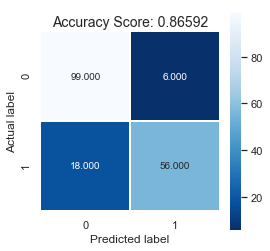

In [15]:
ens = EsemblingClassifier()
ens.fit(X_train, Y_train)
ens_prediction = ens.predict(X_test)
score = metrics.accuracy_score(Y_test, ens_prediction)
display_confusion_matrix(Y_test, ens_prediction, score=score)

## **6. 予測結果出力** <a id="submission"></a>

In [16]:
test_df_raw = pd.read_csv(path_test)
test = test_df_raw.copy()
test = preprocess_data(test)
test = pd.DataFrame(sc.fit_transform(test.values), index=test.index, columns=test.columns)
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamillySize,IsAlone,IsChild,TicketSurvivor
0,0.873482,-0.755929,0.376278,-0.499470,-0.400248,-0.497185,-0.319455,2.243165,-0.756787,-0.664957,0.807573,-0.347338,-0.3253
1,0.873482,1.322876,1.340981,0.616992,-0.400248,-0.512048,-0.319455,-0.677841,1.245346,0.731787,-1.238278,-0.347338,-0.3253
2,-0.315819,-0.755929,2.498625,-0.499470,-0.400248,-0.463874,-0.319455,2.243165,0.244279,-0.664957,0.807573,-0.347338,-0.3253
3,0.873482,-0.755929,-0.202543,-0.499470,-0.400248,-0.482248,-0.319455,-0.677841,1.245346,-0.664957,0.807573,-0.347338,-0.3253
4,0.873482,1.322876,-0.588425,0.616992,0.619896,-0.417269,-0.319455,-0.677841,-0.756787,0.731787,-1.238278,-0.347338,-0.3253


In [17]:
# アンサンブル学習
model_test = EsemblingClassifier()
model_test.fit(X, Y)

# テストデータ予測
prediction = model_test.predict(test)

result_df = test_df_raw.copy()
result_df['Survived'] = prediction
result_df.to_csv('submission.csv', columns=['PassengerId', 'Survived'], index=False)

-------- Fitting models --------
-------- Making and combining predictions --------


In [18]:
result_df[['PassengerId', 'Survived']].head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


結果：0.78947